In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/Exp_Proj_5490/Project/EP5490_Data.xlsx')

In [ ]:
df = df1.copy()

***DATA CLEANING AND INSPECTING***

In [ ]:
df.isnull().sum()

Annonymized ID                             0
Job Code                                   0
Job Title                                  0
Job Function                               0
Job Category                               0
Job Group                                  0
Compa Ratio                                0
Pay Level                                  5
Work Location                              0
Work Country                               0
Work Region                                0
Gender                                     0
Employee Status                            0
Termination Date                       11668
Tenure                                     0
Tenure Bucket                              0
Base Pay Mid Point Annualized              0
Currency Conversion Rate                   5
Generation                                 1
Work Structure                          8947
Termination Type                       11668
Termination Reason                     11669
Cost to Re

**** Column Name Editing ****

In [ ]:
# before lowercase
df.columns

Index(['Annonymized ID', 'Job Code', 'Job Title', 'Job Function',
       'Job Category', 'Job Group', 'Compa Ratio', 'Pay Level',
       'Work Location', 'Work Country', 'Work Region', 'Gender',
       'Employee Status', 'Termination Date', 'Tenure', 'Tenure Bucket',
       'Base Pay Mid Point Annualized', 'Currency Conversion Rate',
       'Generation', 'Work Structure', 'Termination Type',
       'Termination Reason ', 'Cost to Replace Employee Multiplier'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df = df.rename(columns={'annonymized id': 'anon id', 'termination reason ': 'termination reason'})

In [ ]:
# after lowercase and editing
df.columns

Index(['anon id', 'job code', 'job title', 'job function', 'job category',
       'job group', 'compa ratio', 'pay level', 'work location',
       'work country', 'work region', 'gender', 'employee status',
       'termination date', 'tenure', 'tenure bucket',
       'base pay mid point annualized', 'currency conversion rate',
       'generation', 'work structure', 'termination type',
       'termination reason', 'cost to replace employee multiplier'],
      dtype='object')

*** Dropping NA's and duplicates ***

In [ ]:
df = df.dropna(subset=['generation', 'pay level', 'currency conversion rate']).drop_duplicates()

*** Editing Work Country / Location / Structure for clarity ***

In [ ]:
# before
df['work location'].tail(10)

25985      Fremont United States
25986      Fremont United States
25987      Fremont United States
25988     Longmont United States
25989      Fremont United States
25990     Longmont United States
25991      Fremont United States
25992     Longmont United States
25993     Longmont United States
25994    Cupertino United States
Name: work location, dtype: object

In [ ]:
# removing work country from work location, given we have a work country column already
df['work location'] = df.apply(lambda row: row['work location'].replace(row['work country'], '').strip(), axis=1)
df = df.rename(columns = {'work location':'work city'})

In [ ]:
# editing work city names
df['work city'] = df['work city'].replace({'Remote  - British Columbia': 'British Columbia',
                                         'Portland, Oregon': 'Portland',
                                         'Remote Republic of': 'Ireland',
                                         'Remote  - Ontario': 'Ontario',
                                         'Remote Northern Ireland': 'N Ireland',
                                          '': 'Hong Kong'})


In [ ]:
df[['work city', 'work country']].tail(10)

,work city,work country
25985,Fremont,United States
25986,Fremont,United States
25987,Fremont,United States
25988,Longmont,United States
25989,Fremont,United States
25990,Longmont,United States
25991,Fremont,United States
25992,Longmont,United States
25993,Longmont,United States
25994,Cupertino,United States


*** Tenure Rounding ***

In [ ]:
df['tenure']

0        32.194521
1        31.079452
2        33.101370
3        32.969863
4        32.947945
           ...    
25990    32.213699
25991    33.421918
25992    28.002740
25993    27.947945
25994    27.827397
Name: tenure, Length: 25989, dtype: float64

In [ ]:
df['tenure'] = df['tenure'].round(2)

In [ ]:
df['tenure']

0        32.19
1        31.08
2        33.10
3        32.97
4        32.95
         ...  
25990    32.21
25991    33.42
25992    28.00
25993    27.95
25994    27.83
Name: tenure, Length: 25989, dtype: float64

*** Feature Engineering ***

In [ ]:
# feature engineering - cost to replace employee
df['cost to replace employee'] = df['base pay mid point annualized'] * df['cost to replace employee multiplier']

In [ ]:
# currency conversion
df['usd base pay mid point'] = df['base pay mid point annualized'] * df['currency conversion rate']
df = df.drop(['base pay mid point annualized', 'currency conversion rate'], axis=1)

*** Sanity Checking Compa Ratio / dropping excessive values ***

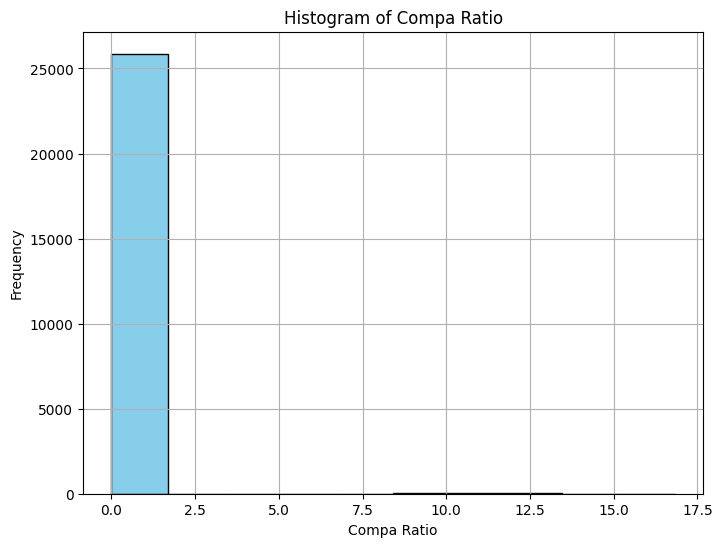

In [ ]:
# histogram BEFORE compa ratio handling
plt.figure(figsize=(8, 6))
plt.hist(df['compa ratio'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Compa Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Compa Ratio')
plt.grid(True)
plt.show()

In [ ]:
df = df[df['compa ratio'] <= 2]
df = df[df['compa ratio'] >= .25]

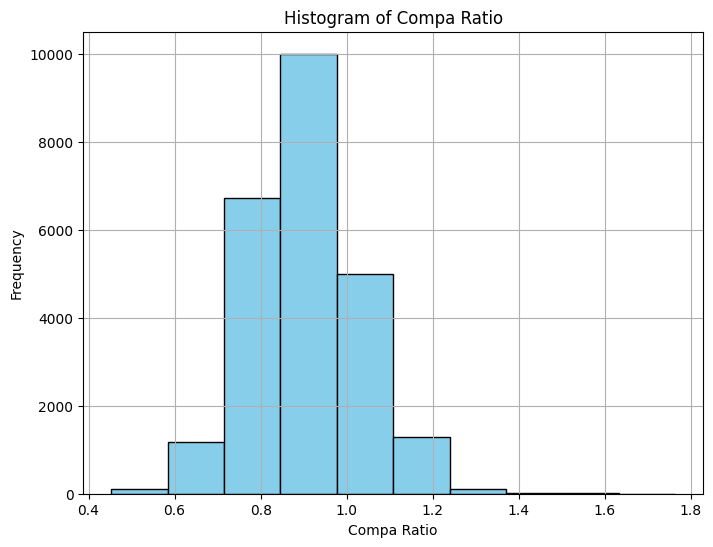

In [ ]:
# # histogram AFTER compa ratio handling

plt.figure(figsize=(8, 6))
plt.hist(df['compa ratio'], bins=10 , color='skyblue', edgecolor='black')
plt.xlabel('Compa Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Compa Ratio')
plt.grid(True)
plt.show()

In [ ]:
# removing the 6 mystery nulls in work city
df = df.dropna(subset = ['work city'])

*** vol_churn and work structure editing ***

In [ ]:
# voluntary churn column
df['vol_churn'] = (df['termination type'] == 'Voluntary Termination').astype(int)

# filling work structure NA's
df['work structure'] = df['work structure'].fillna('Onsite')


In [ ]:
df['vol_churn']

0        0
1        1
2        0
3        0
4        0
        ..
25990    0
25991    0
25992    0
25993    0
25994    0
Name: vol_churn, Length: 24409, dtype: int64

In [ ]:
# dropping retirement termination reasons
df = df.drop(df[(df['termination reason'] == 'Retirement') | (df['termination reason'] == 'Retirement (Rehired)') |
                (df['termination reason'] == 'Deceased')].index)

In [ ]:
# keeping only voluntary termination and active employees
df = df.drop(df[(df['termination type'] == 'Involuntary Termination') | (df['termination type'] == 'Other Termination') |
 (df['termination type'] == 'Release Termination')].index)


In [ ]:
df['termination type'].value_counts()

termination type
Voluntary Termination    5859
No Show                     1
Name: count, dtype: int64

In [ ]:
df = df.drop(columns = ['termination type'])

*** binning compa ratio ***

In [ ]:
df['compa ratio']

1        0.979
2        1.146
3        0.941
4        0.932
7        1.079
         ...  
25979    0.851
25981    0.976
25984    0.936
25988    0.954
25991    0.841
Name: compa ratio, Length: 17528, dtype: float64

In [ ]:
bins = [0, 0.25, 0.5, 0.75, 1, float('inf')]

# Define the bin labels
labels = ['1-25%', '25-50%', '50-75%', '75-100%', '100%+']

# Bin the 'compensation ratio' column
df['compa bucket'] = pd.cut(df['compa ratio'], bins=bins, labels=labels, right=False)


In [ ]:
df['compa bucket']

1        75-100%
2          100%+
3        75-100%
4        75-100%
7          100%+
          ...   
25979    75-100%
25981    75-100%
25984    75-100%
25988    75-100%
25991    75-100%
Name: compa bucket, Length: 17528, dtype: category
Categories (5, object): ['1-25%' < '25-50%' < '50-75%' < '75-100%' < '100%+']

*** binning tenure***


In [ ]:
df['tenure']

1        31.08
2        33.10
3        32.97
4        32.95
7        33.12
         ...  
25979    32.62
25981    33.69
25984    10.62
25988    30.51
25991    33.42
Name: tenure, Length: 17528, dtype: float64

In [ ]:
# Define the bin edges for tenure
tenure_bins = [0, 1, 5, 10, 20, float('inf')]

# Define the bin labels for tenure
tenure_labels = ['<1', '1-5', '5-10', '10-20', '20+']

# Custom function to map and bin the 'tenure bucket' column
def map_and_bin_tenure(bucket):
    if bucket == '< 1 Year':
        return '0'
    elif bucket == '1 - 3 Years':
        return '3'
    elif bucket == '3 - 5 Years':
        return '2'
    elif bucket == '5 - 10 Years':
        return '3'
    elif bucket == '10 - 20 Years':
        return '4'
    elif bucket == '20+ Years':
        return '5'
    else:
        return None

# Apply the custom function to map and bin the 'tenure bucket' column
df['tenure bucket'] = df['tenure bucket'].apply(map_and_bin_tenure)

In [ ]:
df['tenure bucket']

1        5
2        5
3        5
4        5
7        5
        ..
25979    5
25981    5
25984    4
25988    5
25991    5
Name: tenure bucket, Length: 17528, dtype: object

In [ ]:
df['tenure bucket'] = df['tenure bucket'].astype(str).astype(int)

In [ ]:
df.isnull().sum()

anon id                                    0
job code                                   0
job title                                  0
job function                               0
job category                               0
job group                                  0
compa ratio                                0
pay level                                  0
work city                                  0
work country                               0
work region                                0
gender                                     0
employee status                            0
termination date                       11668
tenure                                     0
tenure bucket                              0
generation                                 0
work structure                             0
termination reason                     11669
cost to replace employee multiplier        0
cost to replace employee                   0
usd base pay mid point                     0
vol_churn 

*** creating active year features ***

In [ ]:
# df['termination date'] = pd.to_datetime(df['termination date'])
# df['quarter'] = df['termination date'].dt.year.astype(str) + ' Q' + df['termination date'].dt.quarter.astype(str)

In [ ]:
# # Create a list of years from 2016 to 2024
# years = range(2016, 2025)

# # Create an empty DataFrame to store the results
# df_quarters = pd.DataFrame()

# # Loop through each year and quarter
# for year in years:
#     for quarter in range(1, 5):  # Quarters range from 1 to 4
#         quarter_name = f"{year} Q{quarter}"
#         df_quarters[quarter_name] = np.where(df['quarter'] <= f"{year}-Q{quarter}", "Active", "NaN")

# # Concatenate the new DataFrame with df
# df = pd.concat([df, df_quarters], axis=1)

*** final touches ***

In [ ]:
# df = df.drop(columns = ['anon id', 'job code', 'employee status', 'termination date',
#       'termination reason', 'cost to replace employee multiplier', 'cost to replace employee',
#        'usd base pay mid point', 'compa ratio', # created compa bucket
#                         'tenure']) #have tenure bucket

In [ ]:
# df = df.reset_index(drop=True)

*** EXPORT CLEAN DATA ***

In [ ]:
df.to_csv('clean_df_copy.csv', index=False)

In [ ]:
df

,anon id,job code,job title,job function,job category,job group,compa ratio,pay level,work city,work country,...,tenure,tenure bucket,generation,work structure,termination reason,cost to replace employee multiplier,cost to replace employee,usd base pay mid point,vol_churn,compa bucket
1,1112,8804_USA BA,Managing Principal Engineer,Engineering,Management,Management,0.979,M4,Fremont,United States,...,31.08,5,Boomer,Onsite,Compensation/Pay,1.25,253760.0,203008.0,1,75-100%
2,1113,1600_USA NTL,Staff Engineer,Engineering,Engineering Professional,Professional,1.146,P4,Remote US,United States,...,33.10,5,Boomer,Remote,NaN,1.25,148746.0,118996.8,0,100%+
3,1115,3627_USA BA,Sr Staff Program/Project Manager,Information Technology,Professional,Professional,0.941,P5,Fremont,United States,...,32.97,5,Gen X,Onsite,NaN,1.25,231244.0,184995.2,0,75-100%
4,1116,2692_USA NTL,Technologist,Engineering,Engineering Professional,Professional,0.932,P7,Longmont,United States,...,32.95,5,Boomer,Onsite,NaN,1.25,312494.0,249995.2,0,75-100%
7,1120,1486_USA BA,Sr Engineering Specialist,Engineering Services,Operations Support,Support,1.079,S5,Fremont,United States,...,33.12,5,Gen X,Onsite,NaN,0.50,50003.2,100006.4,0,100%+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25979,87546,2378_USA NTL,Sr Manager,Information Technology,Management,Management,0.851,M4,Longmont,United States,...,32.62,5,Gen X,Onsite,Career Advancement,1.25,231244.0,184995.2,1,75-100%
25981,87548,1206_USA BA,Engineering Specialist IV,Engineering Services,Operations Support,Support,0.976,S4,Fremont,United States,...,33.69,5,Boomer,Onsite,NaN,0.50,44501.6,89003.2,0,75-100%
25984,87552,1474_USA BA,Sr Engineer,Engineering,Engineering Professional,Professional,0.936,P3,Fremont,United States,...,10.62,4,Boomer,Onsite,Change of Career Direction,1.25,156260.0,125008.0,1,75-100%
25988,87556,2472_USA NTL,Sr Staff Engineer,Engineering,Engineering Professional,Professional,0.954,P5,Longmont,United States,...,30.51,5,Boomer,Onsite,NaN,1.25,227500.0,182000.0,0,75-100%


In [ ]:
df['termination date']

1       2022-02-04
2              NaT
3              NaT
4              NaT
7              NaT
           ...    
25979   2022-06-08
25981          NaT
25984   2023-04-17
25988          NaT
25991          NaT
Name: termination date, Length: 17528, dtype: datetime64[ns]

In [ ]:
df['termination date'] = pd.to_datetime(df['termination date'])

# Extract year from 'termination_date' column
df['termination year'] = df['termination date'].dt.year

# Group data by 'termination_year' and count terminations
termination_counts = df.groupby('termination year').size().reset_index(name='termination count')

# Calculate average terminations per year
average_terminations_per_year = termination_counts['termination count'].mean()

print("Average number of terminations per year:", average_terminations_per_year)

Average number of terminations per year: 651.1111111111111


In [ ]:
termination_counts

,termination year,termination count
0,2016.0,180
1,2017.0,1149
2,2018.0,865
3,2019.0,636
4,2020.0,458
5,2021.0,761
6,2022.0,962
7,2023.0,729
8,2024.0,120
